In [ ]:
#!pip uninstall opencv-python
#!pip install opencv-contrib-python
#!conda install -c michael_wild opencv-contrib

<IPython.core.display.Javascript object>


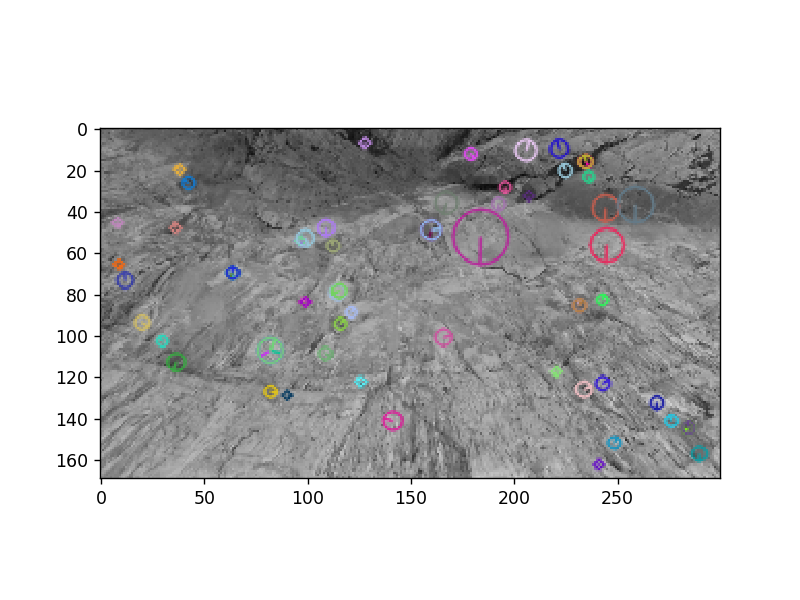

In [1]:
%matplotlib notebook

import cv2
import matplotlib.pyplot as plt
import signal

skip_frames = 7;

# Signal handler which ensures that video source is released correctly when interrupted
def signal_handler(signal, frame):
    # KeyboardInterrupt detected, exiting
    global is_interrupted
    is_interrupted = True
signal.signal(signal.SIGINT, signal_handler)
is_interrupted = False

def preprocess_image(frame):
    # Convert for matplotlib color format
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # To gray
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    
    # Before coputing key points, reduce image size if it too large
    width = frame.shape[1]
    max_width = 300
    if width > max_width:
        multiplier = max_width/width
        frame = cv2.resize(frame, (0,0), fx=multiplier, fy=multiplier) 
    return frame

    
class SiftReconstructor:
    def __init__(self):
        self.previous_descriptors = []
        
        # Keypoint detection algorithm
        self.kpalgo = cv2.xfeatures2d.SIFT_create(sigma=4,
                                                nfeatures=200,
                                                #contrastThreshold=0.05,
                                                 )
        
        # FLANN parameters
        FLANN_INDEX_KDTREE = 0
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks=50)   # or pass empty dictionary 
        self.flann = cv2.FlannBasedMatcher(index_params,search_params)

    def process_frame(self,img):
        gray = preprocess_image(img)
    
        #kp = kpalgo.detect(gray,None)
        keypoints, descriptors = self.kpalgo.detectAndCompute(gray,None)

        matches = self._find_matches(descriptors)

        self.keypoints_descriptors = descriptors

        # Draw keypoints to image
        img_kp = cv2.drawKeypoints(gray,keypoints,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
        return img_kp
    
    def _find_matches(self,descriptors):
        if len(self.previous_descriptors) > 0:
            matches = self.flann.knnMatch(self.self.keypoints_descriptors,descriptors,k=2)
        else:
            matches = []
        self.keypoints_descriptors = descriptors
        
        matchesMask = [[0,0] for i in range(len(matches))]

        # ratio test as per Lowe's paper
        for i,(m,n) in enumerate(matches):
            if m.distance < 0.7*n.distance:
               matchesMask[i]=[1,0]
    

# Video source
#source = cv2.VideoCapture(0)
source = cv2.VideoCapture('YDXJ4244_small.mp4')

# Algorithm for reconstruction
algo = SiftReconstructor()


#Interactive mode on. Default is on, but in off mode will create repeated figures
plt.ion() 

if source.isOpened():
    is_capturing, frame = source.read()
    frame = preprocess_image(frame)
    
    # Craete figure and create preview image
    fig,ax = plt.subplots(1,1)
    preview_window = plt.imshow(frame)    
else:
    # Failed open source
    is_capturing = False

prev_des = []
while is_capturing:
    is_capturing, img = source.read()
    for i in range(skip_frames):
        is_capturing, img = source.read()
        if not is_capturing:
            break
            
    if not is_capturing:
        break
            
    img_kp = algo.process_frame(img)
    
    # Draw image
    preview_window.set_data(img_kp)
    
    # Update canvas. Without the command the image is not updated in jupyter notebook
    fig.canvas.draw()
    
    if is_interrupted:
        break
source.release()